# [DeepSpeed](https://github.com/deepspeedai/DeepSpeed)

### 1. DeepSpeed의 개념
DeepSpeed는 Microsoft에서 개발한 딥러닝 최적화 라이브러리입니다. 대규모 모델을 효율적으로 학습시키기 위해 만들어졌으며, 특히 LLM(Large Language Model) 학습에 매우 유용합니다.

### 2. 왜 DeepSpeed가 필요한가?

#### 문제 상황
- 현대의 LLM은 수십억 개의 파라미터를 가집니다
- 이런 큰 모델을 학습하려면 엄청난 GPU 메모리가 필요합니다
- 일반적인 GPU 하나로는 메모리가 부족합니다
- 학습 속도가 매우 느립니다

#### DeepSpeed의 해결책
DeepSpeed는 다음과 같은 기술들을 통해 이 문제들을 해결합니다:

1. **메모리 최적화**: 모델의 다른 부분들을 여러 GPU에 나누어 저장
2. **계산 최적화**: 병렬 처리를 통해 학습 속도 향상
3. **통신 최적화**: GPU 간 데이터 전송을 효율화


### 3. DeepSpeed의 주요 기능들

#### ZeRO (Zero Redundancy Optimizer)
- **ZeRO Stage 1**: 옵티마이저 상태를 여러 GPU에 분산
- **ZeRO Stage 2**: 그래디언트도 여러 GPU에 분산
- **ZeRO Stage 3**: 모델 파라미터까지 여러 GPU에 분산

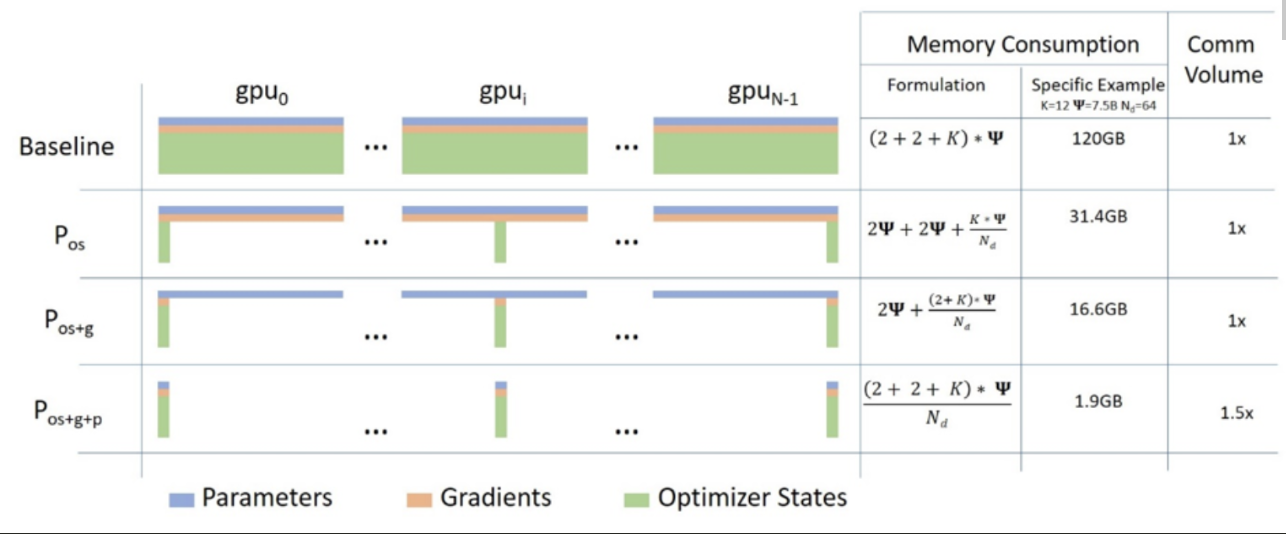

#### 3D Parallelism
- **데이터 병렬**: 같은 모델을 여러 GPU에서 다른 데이터로 학습
- **모델 병렬**: 모델 자체를 여러 GPU에 나누어 배치
- **파이프라인 병렬**: 모델의 레이어들을 순차적으로 여러 GPU에 배치

### 4. DeepSpeed vs 일반 학습 비교

| 구분 | 일반 학습 | DeepSpeed |
|------|-----------|-----------| 
| 메모리 사용량 | 높음 | 낮음 (최대 80% 절약) |
| 학습 속도 | 느림 | 빠름 (여러 GPU 활용) |
| 모델 크기 제한 | GPU 메모리에 의존 | 훨씬 큰 모델 가능 |
| 설정 복잡도 | 간단 | 초기 설정 필요 |


# DeepSpeed 실습 예제

## 1단계: 필요한 라이브러리 설치


In [1]:
# MPI 라이브러리 설치 (DeepSpeed 필수 의존성)
!apt-get update -qq
!apt-get install -y openmpi-bin openmpi-common libopenmpi-dev

# DeepSpeed 및 관련 라이브러리 설치
%pip install deepspeed==0.17.5 transformers==4.56.1 datasets==4.0.0 accelerate==1.10.1 mpi4py==4.1.0

# MPI 설치 확인
!which mpirun
!mpirun --version

print("DeepSpeed 라이브러리 설치가 완료되었습니다!")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  autoconf automake autotools-dev cpp-11 file g++-11 gcc-11 gcc-11-base
  gcc-12-base gfortran gfortran-11 ibverbs-providers javascript-common
  libasan6 libatomic1 libcaf-openmpi-3 libcc1-0 libcoarrays-dev
  libcoarrays-openmpi-dev libevent-2.1-7 libevent-core-2.1-7 libevent-dev
  libevent-extra-2.1-7 libevent-openssl-2.1-7 libevent-pthreads-2.1-7
  libfabric1 libgcc-11-dev libgcc-s1 libgfortran-11-dev libgfortran5 libgomp1
  libhwloc-dev libhwloc-plugins libhwloc15 libibverbs-dev libibverbs1 libitm1
  libjs-jquery libjs-jquery-ui liblsan0 libltdl-dev libltdl7 libmagic-mgc
  libmagic1 libnl-3-200 libnl-3-dev libnl-route-3-200 libnl-route-3-dev
  libnuma-dev libnuma1 libopenmpi3 libpmix-dev libpmix2 libpsm-infinipath1
  libpsm2-2 libquadmath0 librdmacm1 libsigsegv2 libstdc++-11-dev libstdc++6
  libtool libtsan0 libubsan1 libucx0 libxnvctr

## 2단계: 라이브러리 임포트


In [ ]:
import torch
import torch.nn as nn
import deepspeed  # DeepSpeed 라이브러리 임포트
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM,
    get_linear_schedule_with_warmup
)
from datasets import Dataset
import json
import os
import argparse
from torch.utils.data import DataLoader, Dataset

print(f"PyTorch 버전: {torch.__version__}")
print(f"DeepSpeed 버전: {deepspeed.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")


[2025-09-07 03:47:04,903] [INFO] [real_accelerator.py:260:get_accelerator] Setting ds_accelerator to cuda (auto detect)


df: /root/.triton/autotune: No such file or directory
/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


[2025-09-07 03:47:08,230] [INFO] [logging.py:107:log_dist] [Rank -1] [TorchCheckpointEngine] Initialized with serialization = False
PyTorch 버전: 2.8.0.dev20250319+cu128
DeepSpeed 버전: 0.17.5
CUDA 사용 가능: True


## 3단계: DeepSpeed 설정 생성


In [ ]:
def get_deepspeed_config():
    """DeepSpeed 설정을 생성하는 함수"""
    ds_config = {
        # 기본 설정
        "train_batch_size": 4,  # 전체 배치 크기
        "train_micro_batch_size_per_gpu": 2,  # GPU당 마이크로 배치 크기
        "gradient_accumulation_steps": 2,  # 그래디언트 누적 단계
        "steps_per_print": 10,  # 로그 출력 간격
        
        # ZeRO 최적화 설정 (DeepSpeed의 핵심 기능)
        "zero_optimization": {
            "stage": 2,  # ZeRO Stage 2: 옵티마이저 상태 + 그래디언트 분산
            "allgather_partitions": True, # 모든 파티션 수집
            "reduce_scatter": True, # 각 파티션 줄이기
            "allgather_bucket_size": 2e8, # 모든 파티션 수집 버킷 크기
            "reduce_bucket_size": 2e8, # 각 파티션 줄이기 버킷 크기
            "overlap_comm": True, # 통신 중복
            "contiguous_gradients": True, # 연속적인 그래디언트
            "cpu_offload": False  # CPU 오프로드 비활성화 (Colab 환경용)
        },
        
        # 옵티마이저 설정 (DeepSpeed가 관리)
        "optimizer": {
            "type": "AdamW", # 최적화 함수
            "params": {
                "lr": 5e-5, # 학습률
                "betas": [0.9, 0.95], # 베타 값
                "eps": 1e-8, # 작은 값
                "weight_decay": 0.01 # 가중치 감소
            }
        },
        
        # 스케줄러 설정
		"scheduler": {
			"type": "WarmupLR",  # 학습률을 천천히 증가시키며 예열(Warm-up)하는 스케줄러
			"params": {
				"warmup_min_lr": 0,        # 워밍업 시작 시 최소 학습률 (보통 0 또는 매우 작은 값으로 설정)
				"warmup_max_lr": 5e-5,     # 워밍업 종료 시 최대 학습률 (최종 목표 학습률)
				"warmup_num_steps": 100    # 워밍업을 진행할 스텝(step) 수, 해당 스텝 동안 선형적으로 증가
			}
		},

        
        # 혼합 정밀도 학습 (메모리 절약)
        "fp16": {
            "enabled": True, # 혼합 정밀도 학습 활성화
            "initial_scale_power": 15, # 초기 스케일 파워
            "loss_scale_window": 1000, # 손실 스케일 윈도우
            "hysteresis": 2, # 역동적 스케일 조정 하이스테너시
            "min_loss_scale": 1 # 최소 손실 스케일
        },
        
        # 기타 설정
        "wall_clock_breakdown": False, # 시간 측정 비활성화	
        "gradient_clipping": 1.0 # 그래디언트 클리핑
    }
    
    return ds_config

# DeepSpeed 설정 생성
deepspeed_config = get_deepspeed_config()

print("DeepSpeed 설정이 생성되었습니다!")
print("주요 설정:")
print(f"  - ZeRO Stage: {deepspeed_config['zero_optimization']['stage']}")
print(f"  - 배치 크기: {deepspeed_config['train_batch_size']}")
print(f"  - FP16 활성화: {deepspeed_config['fp16']['enabled']}")
print(f"  - 옵티마이저: {deepspeed_config['optimizer']['type']}")


DeepSpeed 설정이 생성되었습니다!
주요 설정:
  - ZeRO Stage: 2
  - 배치 크기: 4
  - FP16 활성화: True
  - 옵티마이저: AdamW


## 4단계: 모델 및 데이터 준비


### LLM 모델 준비

In [ ]:
print("한국어 모델을 로드합니다...")

# 한국어 특화 모델 선택
model_name = "EleutherAI/polyglot-ko-1.3b"  # 1.3B 파라미터

try:
    # 토크나이저 로드
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token is None: # 패딩 토큰이 없으면
        tokenizer.pad_token = tokenizer.eos_token  # 패딩 토큰 설정
    
    # 모델 로드 (DeepSpeed를 위해 device_map 사용 안함)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,  # 메모리 절약을 위한 fp16
        trust_remote_code=True # 신뢰할 수 있는 코드 사용 여부
    )
    
    print("한국어 모델 로드 완료!")
    print(f"모델 파라미터 수: {model.num_parameters():,}")
    
except Exception as e:
    print(f"한국어 모델 로드 실패: {e}")


한국어 모델을 로드합니다...


tokenizer_config.json:   0%|          | 0.00/164 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/640 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/748M [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

한국어 모델 로드 완료!
모델 파라미터 수: 1,331,810,304


### 데이터 준비 

In [5]:
# 한국어 학습 데이터 준비
korean_texts = [
    "인공지능은 우리 일상을 변화시키는 혁신적인 기술입니다. 스마트폰의 음성인식부터 자율주행차까지 다양한 분야에서 활용되고 있습니다.",
    "딥러닝은 인간의 뇌 구조를 모방한 신경망 기술로, 복잡한 패턴 인식과 학습이 가능합니다. 이미지 인식, 자연어 처리 등에서 놀라운 성과를 보여주고 있습니다.",
    "자연어 처리는 컴퓨터가 인간의 언어를 이해하고 생성할 수 있게 하는 기술입니다. 번역, 요약, 질문답변 등 다양한 언어 작업을 자동화할 수 있습니다.",
    "트랜스포머 아키텍처는 현대 자연어 처리의 핵심 기술입니다. 어텐션 메커니즘을 통해 문맥 정보를 효과적으로 처리할 수 있습니다.",
    "파인튜닝은 사전 훈련된 모델을 특정 작업에 맞게 조정하는 과정입니다. 적은 데이터로도 높은 성능을 달성할 수 있는 효율적인 방법입니다.",
    "한국의 사계절은 각각 독특한 아름다움을 가지고 있습니다. 봄의 벚꽃, 여름의 녹음, 가을의 단풍, 겨울의 설경이 모두 매력적입니다.",
    "한국 음식은 발효 문화를 바탕으로 한 건강한 식문화를 자랑합니다. 김치, 된장, 고추장 등은 세계적으로 인정받는 발효식품입니다.",
    "K-팝과 K-드라마는 한류의 중심으로 전 세계에 한국 문화를 알리고 있습니다. 음악과 영상 콘텐츠의 품질이 매우 높습니다."
]

In [6]:
# 텍스트 토큰화 함수
def tokenize_function(texts):
    tokenized = tokenizer(
        texts, # 토큰화할 텍스트
        truncation=True, # 토큰화 시 최대 길이 제한
        padding="max_length", # 최대 길이에 맞게 패딩
        max_length=128, # 최대 길이
        return_tensors="pt" # 토큰화 결과를 텐서로 반환
    )
    tokenized["labels"] = tokenized["input_ids"].clone() # 레이블 복사
    return tokenized

# 데이터셋 생성
tokenized_data = tokenize_function(korean_texts)

In [ ]:
# DataLoader 생성 (DeepSpeed가 분산 처리할 데이터)
class TextDataset(Dataset):
    def __init__(self, tokenized_data):
        self.input_ids = tokenized_data["input_ids"] # 토큰화된 입력 아이디
        self.attention_mask = tokenized_data["attention_mask"] # 어텐션 마스크
        self.labels = tokenized_data["labels"] # 레이블
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }


In [8]:
dataset = TextDataset(tokenized_data)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

print(f"데이터 준비 완료! 총 {len(dataset)}개 샘플")


데이터 준비 완료! 총 8개 샘플


## 5단계: DeepSpeed 초기화

**이 부분이 DeepSpeed의 핵심입니다!**
- `deepspeed.initialize()`로 모델, 옵티마이저, 데이터로더를 DeepSpeed 엔진으로 래핑
- ZeRO 최적화가 자동으로 적용됨
- 메모리 효율성과 분산 학습이 활성화됨


In [9]:
# DeepSpeed 명령행 인자 시뮬레이션 (Colab 환경용)
class Args:
    def __init__(self):
        self.local_rank = -1  # 단일 GPU 환경
        self.deepspeed = True

args = Args()

In [ ]:
# DeepSpeed 초기화 - 이것이 핵심!
print("DeepSpeed 초기화를 시작합니다...")
print("=" * 50)
is_deepspeed = False  # DeepSpeed 사용 여부 플래그

try:
    # deepspeed.initialize() - DeepSpeed의 핵심 함수
    model_engine, optimizer, train_dataloader, _ = deepspeed.initialize(
        args=args,  # 명령행 인자
        model=model,  # 학습할 모델
        model_parameters=model.parameters(),  # 모델 파라미터
        training_data=dataset,  # 학습 데이터
        config=deepspeed_config  # DeepSpeed 설정
    )
    
    print("DeepSpeed 초기화 성공!")
    print(f"  - 엔진 타입: {type(model_engine)}")
    print(f"  - ZeRO Stage: {model_engine.zero_optimization_stage()}")
    print(f"  - FP16 활성화: {model_engine.fp16_enabled()}")
    print(f"  - Local Rank: {model_engine.local_rank}")
    
    if torch.cuda.is_available():
        print(f"  - GPU 메모리 (초기화 후): {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    
    is_deepspeed = True  # DeepSpeed 사용 여부 플래그
    
except Exception as e:
    print(f"DeepSpeed 초기화 실패: {e}")


DeepSpeed 초기화를 시작합니다...
[2025-09-07 03:47:17,470] [INFO] [logging.py:107:log_dist] [Rank -1] DeepSpeed info: version=0.17.5, git-hash=unknown, git-branch=unknown
[2025-09-07 03:47:17,473] [INFO] [comm.py:821:init_distributed] cdb=None
[2025-09-07 03:47:17,474] [INFO] [comm.py:836:init_distributed] Not using the DeepSpeed or dist launchers, attempting to detect MPI environment...
[2025-09-07 03:47:18,120] [INFO] [comm.py:891:mpi_discovery] Discovered MPI settings of world_rank=0, local_rank=0, world_size=1, master_addr=172.16.16.2, master_port=29500
[2025-09-07 03:47:18,122] [INFO] [comm.py:852:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl
[2025-09-07 03:47:18,310] [INFO] [config.py:684:__init__] Config mesh_device None world_size = 1
[2025-09-07 03:47:18,311] [WARNING] [config_utils.py:70:_process_deprecated_field] Config parameter cpu_offload is deprecated use offload_optimizer instead


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[2025-09-07 03:47:18,890] [INFO] [engine.py:1356:_configure_distributed_model] ********** distributed groups summary **********
	 self.dp_world_size=1
	 self.mp_world_size=1
	 self.seq_dp_world_size=1
	 self.sequence_parallel_size=1
***********************************************
[2025-09-07 03:47:18,909] [INFO] [logging.py:107:log_dist] [Rank 0] DeepSpeed Flops Profiler Enabled: False


Using /root/.cache/torch_extensions/py311_cu128 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py311_cu128/fused_adam...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py311_cu128/fused_adam/build.ninja...
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2330: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module fused_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output multi_tensor_adam.cuda.o.d -DTORCH_EXTENSION_NAME=fused_adam -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1016\" -I/usr/local/lib/python3.11/dist-packages/deepspeed/ops/csrc/includes -I/usr/local/lib/python3.11/dist-packages/deepspeed/ops/csrc/adam -isystem /usr/local/lib/python3.11/dist-packages/torch/include -isystem /usr/local/lib/python3.11/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/include -isystem /usr/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=1 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_86,code=compute_86 -gencode=arch=compute_86,code=sm_86 --compiler-options '-fPIC' -O3 -DVERSION_GE_1_1 -DVERSION_GE_1_3 -DVERSION_GE_1_5 -lineinfo --use_fast_math -g

Loading extension module fused_adam...


[2025-09-07 03:47:46,619] [INFO] [utils.py:781:see_memory_usage] Before initializing optimizer states
[2025-09-07 03:47:46,621] [INFO] [utils.py:782:see_memory_usage] MA 7.44 GB         Max_MA 9.92 GB         CA 9.93 GB         Max_CA 10 GB 
[2025-09-07 03:47:46,623] [INFO] [utils.py:789:see_memory_usage] CPU Virtual Memory:  used = 116.03 GB, percent = 23.0%
[2025-09-07 03:47:46,797] [INFO] [utils.py:781:see_memory_usage] After initializing optimizer states
[2025-09-07 03:47:46,798] [INFO] [utils.py:782:see_memory_usage] MA 7.44 GB         Max_MA 12.4 GB         CA 14.89 GB         Max_CA 15 GB 
[2025-09-07 03:47:46,800] [INFO] [utils.py:789:see_memory_usage] CPU Virtual Memory:  used = 116.02 GB, percent = 23.0%
[2025-09-07 03:47:46,801] [INFO] [stage_1_and_2.py:605:__init__] optimizer state initialized
[2025-09-07 03:47:46,970] [INFO] [utils.py:781:see_memory_usage] After initializing ZeRO optimizer
[2025-09-07 03:47:46,972] [INFO] [utils.py:782:see_memory_usage] MA 7.44 GB         

## 6단계: DeepSpeed 학습 루프 실행

**DeepSpeed 학습의 특징:**
- `model_engine.backward()`: 자동 그래디언트 스케일링
- `model_engine.step()`: ZeRO 최적화된 파라미터 업데이트
- 메모리 사용량이 크게 절약됨


In [ ]:
print("학습을 시작합니다!")
print("=" * 50)

# 학습 전 메모리 확인
if torch.cuda.is_available():
    print(f"학습 전 GPU 메모리: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

# 입력 데이터를 적절한 디바이스로 이동
if hasattr(model_engine, 'local_rank') and hasattr(model_engine, 'zero_optimization_stage'):
    device = f"cuda:{model_engine.local_rank}" if model_engine.local_rank != -1 else "cuda"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_engine.to(device)

model_engine.train()
total_loss = 0
num_steps = 0

try:
    for step, batch in enumerate(train_dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        # 모델 순전파
        outputs = model_engine(input_ids=input_ids, 
								attention_mask=attention_mask, 
								labels=labels)
        
        loss = outputs.loss
        
        # DeepSpeed vs 일반 학습 구분
        if is_deepspeed:
            # DeepSpeed 역전파 (자동 스케일링 포함)
            model_engine.backward(loss)
            # DeepSpeed 옵티마이저 스텝 (ZeRO 최적화 적용)
            model_engine.step()
            print(f"DeepSpeed 학습 중...")
        else:
            # 일반 학습
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print(f"일반 학습 중...")
        
        total_loss += loss.item()
        num_steps += 1
        
        if step % 2 == 0:
            avg_loss = total_loss / num_steps
            method = "DeepSpeed" if is_deepspeed else "일반"
            print(f"  Step {step} ({method}): Loss = {loss.item():.4f}, Avg Loss = {avg_loss:.4f}")
            
            if torch.cuda.is_available():
                current_memory = torch.cuda.memory_allocated() / 1024**2
                print(f"    현재 GPU 메모리: {current_memory:.2f} MB")
        
        # 간단한 실습을 위해 5스텝만 실행
        if step >= 4:
            break
    
    final_avg_loss = total_loss / num_steps
    print("\n" + "=" * 50)
    method = "DeepSpeed" if is_deepspeed else "일반"
    print(f"{method} 학습 완료!")
    print(f"  - 총 스텝: {num_steps}")
    print(f"  - 평균 손실: {final_avg_loss:.4f}")
    
    if torch.cuda.is_available():
        final_memory = torch.cuda.memory_allocated() / 1024**2
        print(f"  - 최종 GPU 메모리: {final_memory:.2f} MB")
    
except Exception as e:
    print(f"학습 중 오류 발생: {e}")
    import traceback
    traceback.print_exc()

학습을 시작합니다!
학습 전 GPU 메모리: 7620.68 MB


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


DeepSpeed 학습 중...
  Step 0 (DeepSpeed): Loss = 9.0477, Avg Loss = 9.0477
    현재 GPU 메모리: 10239.85 MB
[2025-09-07 03:47:48,020] [INFO] [loss_scaler.py:191:update_scale] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 32768, but hysteresis is 2. Reducing hysteresis to 1
DeepSpeed 학습 중...
DeepSpeed 학습 중...
  Step 2 (DeepSpeed): Loss = 8.7598, Avg Loss = 9.0050
    현재 GPU 메모리: 10239.85 MB
[2025-09-07 03:47:48,265] [INFO] [loss_scaler.py:184:update_scale] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 32768, reducing to 16384
DeepSpeed 학습 중...

DeepSpeed 학습 완료!
  - 총 스텝: 4
  - 평균 손실: 8.9911
  - 최종 GPU 메모리: 7699.62 MB


## 7단계: 학습된 모델 테스트


In [ ]:
print("학습된 모델을 테스트합니다...")
print("=" * 50)

# DeepSpeed 모델을 평가 모드로 전환
model_engine.eval()

# 한국어 테스트 프롬프트들
test_prompts = [
    "인공지능은",
    "한국의 전통문화는", 
    "딥러닝 기술의 미래는"
]

# 각 프롬프트에 대해 텍스트 생성
for i, prompt in enumerate(test_prompts, 1):
    print(f"\n테스트 {i}: '{prompt}'")
    
    try:
        # 입력 토큰화
        inputs = tokenizer.encode(
            prompt,
            return_tensors="pt"
        )
        
        # 적절한 디바이스로 이동
        if hasattr(model_engine, 'local_rank') and hasattr(model_engine, 'zero_optimization_stage'):
            device = f"cuda:{model_engine.local_rank}" if model_engine.local_rank != -1 else "cuda"
        else:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        
        inputs = inputs.to(device)
        
        # 모델로 텍스트 생성 (DeepSpeed 또는 일반)
        with torch.no_grad():
            outputs = model_engine.generate(
                inputs, # 입력 토큰
                max_length=70, # 최대 길이
                num_return_sequences=1, # 반환 시퀀스 수
                temperature=0.7, # 온도
                pad_token_id=tokenizer.eos_token_id, # 패딩 토큰 ID
                do_sample=True, # 샘플링 사용
                top_p=0.9, # 확률 토큰 샘플링
                no_repeat_ngram_size=2 # 반복 방지 크기
            )
        
        # 생성된 텍스트 디코딩
        generated_text = tokenizer.decode(
            outputs[0], # 첫 번째 생성 텍스트(보통 첫번째만 사용)
            skip_special_tokens=True # 특수 토큰 건너뛰기
        )
        print(f"생성 결과: {generated_text}")
        
    except Exception as e:
        print(f"생성 실패: {e}")

print("\n" + "=" * 50)
method = "DeepSpeed" if is_deepspeed else "일반"
print(f"{method} 파인튜닝 완료!")


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


학습된 모델을 테스트합니다...

테스트 1: '인공지능은'
생성 결과: 인공지능은 인간의 모든 활동을 기계로 대체하는 것을 말합니다.​※ 출처 : 네이버 지식백과– 사물인터넷(Internet of Things) : 인간과 사물이 소통하게 해주는 기술.- 인공지능(Artificial Intelligence): 인간 수준

테스트 2: '한국의 전통문화는'
생성 결과: 한국의 전통문화는 한민족이 한반도에 정착한 후 농경문화를 기반으로 정착되었다. 그러나, 산업화, 도시화가 진행되면서 전통적인 농경사회의 모습은 사라지고, 현대문명의 발달과 함께 소비문화가 확산되고 있다, 특히, 경제발전으로 인한 생활수준의 향상과 더불

테스트 3: '딥러닝 기술의 미래는'
생성 결과: 딥러닝 기술의 미래는 어떤 모습일까?​※ AI는 '기술'이다. 기술에 대한 이해가 선행되어야만 AI의 활용이 가능하다! AI를 알기 위해서는 인공지능이 무엇인지부터 알아야 한다. AI가 무엇이고, AI에 대해 왜 알 필요가 있는지,

DeepSpeed 파인튜닝 완료!


## DeepSpeed 부분 요약 및 설명

### 1. DeepSpeed 핵심 코드 위치:

#### **3단계**: DeepSpeed 설정 (`get_deepspeed_config()`)
```python
# ZeRO 최적화 설정
"zero_optimization": {
    "stage": 2,  # ZeRO Stage 2
    "allgather_partitions": True,
    "reduce_scatter": True,
    "cpu_offload": False
}
```

#### **5단계**: DeepSpeed 초기화 (`deepspeed.initialize()`)
```python
model_engine, optimizer, train_dataloader, _ = deepspeed.initialize(
    args=args,
    model=model,
    model_parameters=model.parameters(),
    training_data=dataset,
    config=deepspeed_config
)
```

#### **6단계**: DeepSpeed 학습 루프
```python
# 일반 학습과 다른 점:
model_engine.backward(loss)  # 자동 그래디언트 스케일링
model_engine.step()         # ZeRO 최적화된 업데이트
```

### 2. DeepSpeed vs 일반 학습의 차이점:

| 구분 | 일반 학습 | DeepSpeed |
|------|-----------|----------|
| 초기화 | `model = Model()` | `model_engine, _, _, _ = deepspeed.initialize()` |
| 역전파 | `loss.backward()` | `model_engine.backward(loss)` |
| 옵티마이저 | `optimizer.step()` | `model_engine.step()` |
| 메모리 최적화 | 없음 | ZeRO Stage 2 적용 |
| 자동 스케일링 | 수동 설정 | 자동 FP16 스케일링 |


### 3. 주요 DeepSpeed 기능들:
- **ZeRO Stage 2**: 옵티마이저 상태와 그래디언트를 여러 GPU에 분산
- **FP16 자동 관리**: 메모리 절약과 속도 향상
- **그래디언트 누적**: 큰 배치 효과를 작은 메모리로 구현
- **통신 최적화**: GPU 간 효율적인 데이터 전송
